In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm

import utils
from utils.base import get_params_number, train_loop, init_random_seed, save_texts_to_file
from utils.poetry import LanguageModelDataset, load_chunks, GreedyGenerator, BeamGenerator
from utils.transformer_tools import *

init_random_seed(1702)

In [2]:
# # Предобработка изначального файла, кодировка, уничтожение пустых строк

# with open("datasets/Eragon/Eragon_3books.txt", encoding="utf-8") as input_file:
#     horus = input_file.read().split('\n')
#     horus = [value for value in horus if value != ""]
#     # horus = [value.replace(u'\xa0', u' ') for value in horus]

# with open("datasets/Eragon/Eragon_red.txt", "w", encoding="utf-8") as f:
#     for line in horus:
#         f.write(f"{line}\n")

In [3]:
horus = load_chunks("./datasets/Eragon/Eragon_red.txt", chunk_size=300)

ALL_LEN = len(horus)
print(ALL_LEN)
len_for_steps = int(ALL_LEN / 3)
horus_for_GAN = horus[len_for_steps * 2:]
horus = horus[:len_for_steps * 2]
print(len(horus))
print(len(horus_for_GAN))

23766
15844
7922


In [4]:
horus_train, horus_test = train_test_split(horus, test_size=0.3)

print('Размер обучающей выборки', len(horus_train))
print('Размер валидационной выборки', len(horus_test))

Размер обучающей выборки 11090
Размер валидационной выборки 4754


In [5]:
BPE_MODEL_FILENAME = './models/tokens/eragon_bpe_1000.yttm'

# TRAIN_TEXTS_FILENAME = './datasets/eragon_train.txt'
# save_texts_to_file(horus, TRAIN_TEXTS_FILENAME)
# yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME)

tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ e a t o n r h i s d l u g w m c f y p . , b v k I ’ “ ” E T A S H W R ? x B z N O G j — M D Y - q F ! V C L ; U K û J P : ö í Z ë é Q ‘ á ) ( Û ä 0 / ó î Í 2 â ï ú 5 3 ü 1 7 – ô Ä 9 $ X 8 ° © ] [ 6 4 ê Ú É ▁t he ▁a in ▁s ▁the ed ▁w ou on ▁h re nd er ▁b ▁f ▁o is ra ▁c at ▁to it ing ▁m en ar ▁d ▁and or ▁he ▁of es ll ▁l ▁th an ro as ▁p ▁n ▁“ ▁e ▁in ▁y ad ▁you id ▁I ▁g ld ▁his gh ▁be ▁E rag im ow le ragon ve st ▁T ot ith ▁st ▁Eragon ▁u ▁as ac ▁re ▁on al se ir ▁with ▁S ri ▁it ur ▁that ▁we ▁ha ▁was ver ly ▁A hi ’s .” ▁for ent ght ▁H rom ould ut om ▁The et ce ap ▁her ay ▁an ion ▁him ill ▁sa out ard ▁k ▁R ▁wh her ▁had ▁not ain oo il ▁sh ▁at s, if ic ch s. ran rou ted ▁He ter ore all ▁from ▁have ke ▁me ▁so ▁B pp ▁se ▁W hed ag am ▁they ked ru ▁but ight ▁is ▁said hira aphira ▁Saphira ▁le e, el ▁them ▁sp ec ▁she ▁con e. ▁O ▁their ’t ▁do ▁would ?” th ▁ex ▁were ind hen our ry ong ▁G ▁your ed, ▁su ▁“I ▁kn ▁ne ▁li ▁N ▁— lf ▁then ▁un ed. ack ▁v oran ▁int ▁M and em ble ▁cl ves 

In [5]:
train_token_ids = tokenizer.encode(horus_train, bos=True, eos=True)
test_token_ids = tokenizer.encode(horus_test, bos=True, eos=True)

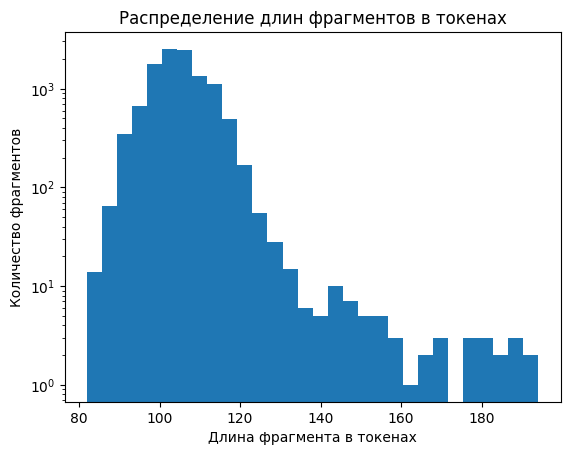

In [6]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.xlabel("Длина фрагмента в токенах")
plt.ylabel("Количество фрагментов")
plt.yscale('log')

In [7]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке', unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


In [8]:
token_ids = tokenizer.encode(horus_for_GAN, bos=True, eos=True)

unknown_subwords_in_test = sum(1 for text in token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов', unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов 0


In [9]:
CHUNK_LENGTH = 110

train_dataset = LanguageModelDataset(train_token_ids, chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids, chunk_length=CHUNK_LENGTH)

In [10]:
tokenizer.decode(list(train_dataset[500]))

['<BOS> e well,” said Brom. “If fortune smiles on us, you may soon have your revenge and the Varden will be rid of a dangerous enemy. What comes after that will be up to you.” Eragon opened his mind and jubilantly told Saphira,We found the Ra’zac’s lair! Where?He quickly explained what they had discovered.H<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'e well,” said Brom. “If fortune smiles on us, you may soon have your revenge and the Varden will be rid of a dangerous enemy. What comes after that will be up to you.” Eragon opened his mind and jubilantly told Saphira,We found the Ra’zac’s lair! Where?He quickly explained what they had discovered.H<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']

In [11]:
model = Language_Model(
    vocab_size = tokenizer.vocab_size(),
    embedding_size = 256,
    backbone = Transformer_Encoder(
        nn.TransformerEncoderLayer(
            d_model = 256,
            nhead = 16,
            dim_feedforward = 512,
            dropout = 0.3
        ),
        num_layers=5
    ),
    emb_dropout = 0.2
)
print('Количество параметров', get_params_number(model))

Количество параметров 3148520


In [23]:
loss_history_all, best_model, optimizer = train_loop(
    model,
    train_dataset,
    test_dataset,
    lm_cross_entropy,
    # save_path="./models/My_models/War/war_2/",
    need_to_save=False,
    lr=1e-4,
    epoch_n=2000,
    batch_size=128,
    device='cuda',
    early_stopping_patience=50,
    # early_optimizer_SD=optimizer_SD,
    max_batches_per_epoch_train=1000,
    max_batches_per_epoch_val=1000,
    lr_scheduler_ctor=lr_scheduler,
    need_to_gen=True,
    tokenizer=tokenizer,
    phrase="For the king and "
)

Эпоха 0
Эпоха: 87 итераций, 9.91 сек
Среднее значение функции потерь на обучении 6.418948677764542
Среднее значение функции потерь на валидации 6.16400839153089
Новая лучшая модель!
For the king and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Эпоха 1
Эпоха: 87 итераций, 8.37 сек
Среднее значение функции потерь на обучении 6.181244121200737
Среднее значение функции потерь на валидации 6.1321773905503125
Новая лучшая модель!
For the king and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Эпоха 2
Эпоха: 87 итераций, 8.61 сек
Среднее значение функции потерь на обучении 6.143658720213791
Среднее значение функции потерь на валидации 6.042273170069644
Новая лучшая модель!
For the king and. the the the. the the the the the the c the c the c the c the c the c the c th

In [24]:
torch.save(best_model.state_dict(), "./models/Lord/Eragon/Lord.pth")
torch.save(optimizer.state_dict(), './models/Lord/Eragon/Lord_opt.pth')

In [25]:
loss_history_all = [str(line) for line in loss_history_all]
save_texts_to_file(loss_history_all, "./models/Lord/Eragon/Lord_1.txt")

### Генерация текста

In [12]:
optimizer_SD = torch.load('./models/Lord/Eragon/Lord_opt.pth')
model.load_state_dict(torch.load('./models/Lord/Eragon/Lord.pth'))

<All keys matched successfully>

In [13]:
beam_generator = BeamGenerator(model, tokenizer)

In [15]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the middle of', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the middle of the city of Eldesti Ingeitum, the Twins Lord River Hrothgar and Nar Lord Rhunödhf
In the middle of his pareness, and he had told a half-beard. He had never seen a few minutes before he was awarenty, but he
In the middle of Alagaësia. The Twins were compared with the Lethrblaka’s capture, but it was aware of the an
In the middle of battle-wearlad, and the celebration of Dras-Leona, the Lethrblaka Burning Palan
In the middle of Dras-Leona — The Sels Letword Du Weldenvarden, By Dragon Wythrblödhren,


In [14]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('Today Sun is', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

Today Sun is hard, but I have no more.” Eragon shrugged. “If I have to find someone in the matters’ request, I’m sure that, but I won’t be
Today Sun islace of Gûnterntera’s Nolf’s Ellesméra. To the Long Knoc Dester Teirm, the
Today Sun is the most important.” “Of course,” said Angela. “Of course,” said Anglet, “but perhaps it is
Today Sun is there, but I have to be able to help anything elsewhere.” “Of course,” said Brom, “but it’s importantly destroy
Today Sun is inform.” “Aye,” said Eragon with his words of words. “Yes, My Lady Nagna,sa Listen Ellesméra


In [16]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('For the king and ', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

For the king and fought to the Varden, who was also suppoies. For the first time of the Forsworn, the Boar, and King Galbatorix’s eggs
For the king and silent hammer in his hand, and he was aware of the motionless scene of the city’s symphren. He was able to
For the king and said, “Eragon, Shur’tugand, Súndrrgrimstblaka — a maetuthield Svlhieldnan —
For the king and dropped to the cave, then returned the door. After a long time, Eragon turned and said, “My Lady Nightstalkí. Welden
For the king and fitnaibrance. The sound of the basiction of the Lethrblaka’s priests. Eragon and his compane


In [17]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('We are going to  ', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

We are going to the Varden.” “Yes,” said Murtagh. “They’naid.” Murtagh shook his head. “I’m going to take off to Gil’ead.” “G
We are going to be able to escape the Empire.” “And if young man.” “Yes, I,” said Oromis, “but I can’t be able to see what I
We are going tomorrow.” “Yes, Master?” “Perhaps,” said Oromis. “Yes, Master.” “And why doesn’t you want to be able to
We are going to the Varden.” “In that case,” said Ajihad. “My family has agreed to me. That’s the only requires of
We are going to follow us,” said Eragon. “becut notice, but I can’t use magic. It’s hard to see you.” “May I,” said Brom, “but
